### 🧊 Lab 4 — Value Iteration and Policy Iteration for Frozen Lake
In this lab we will continue our exploration of Markov Decision Processes (MDPs) 
using the simplified **FrozenLake** environment. Building on Lab 3, we will 
practice two key ideas:

1. **Finding the Optimal Policy (Value Iteration)**  We apply value iteration to compute the optimal state values and extract the corresponding optimal policy that maximizes long-term return.

2. **Finding the Optimal Policy (Policy Iteration)** We apply policy iteration, which alternates between evaluating the current policy and improving it until convergence to the optimal policy.

In [1]:
import gymnasium as gym
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import random
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [2]:
# Define a smaller 3x3 map
DESC_3x3 = [
    "SFF",
    "FHF",
    "FFG",
]
env = gym.make("FrozenLake-v1",desc=DESC_3x3,is_slippery=True, render_mode="ansi")
obs, info = env.reset(seed=42)
print(env.render())


SFF
FHF
FFG



In [3]:
# General transition builder for FrozenLake-style maps (works for any rectangular map).
# Compatible with Gymnasium's action order: LEFT=0, DOWN=1, RIGHT=2, UP=3

from typing import List, Tuple
import numpy as np

LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3
ACTIONS = [LEFT, DOWN, RIGHT, UP]
DIRS = {
    LEFT:  (0, -1),
    DOWN:  (1, 0),
    RIGHT: (0, 1),
    UP:    (-1, 0),
}

def _grid_to_idx(r: int, c: int, ncols: int) -> int:
    return r * ncols + c

def _idx_to_grid(s: int, ncols: int) -> Tuple[int, int]:
    return divmod(s, ncols)

def _clip_move(r: int, c: int, dr: int, dc: int, nrows: int, ncols: int) -> Tuple[int, int]:
    rr, cc = r + dr, c + dc
    rr = min(max(rr, 0), nrows - 1)
    cc = min(max(cc, 0), ncols - 1)
    return rr, cc

def build_frozenlake_transitions(desc: List[str], is_slippery: bool = True):
    """
    Build transition probabilities for a FrozenLake-like grid.

    Args:
        desc: list of strings (rows), made of {'S','F','H','G'}.
        is_slippery: if True -> stochastic: {left, forward, right} each with prob 1/3.
                     if False -> deterministic in the intended direction.

    Returns:
        P: np.ndarray (S, A, S), transition probabilities
        R: np.ndarray (S, A, S), rewards (1 on entering 'G', else 0)
        absorbing: np.ndarray (S,), True for 'H' or 'G' (absorbing/self-loop)
        shape_2d: (nrows, ncols)
        flatten_map: np.ndarray (S,), identity map (r,c)->s ordering
    """
    nrows = len(desc)
    ncols = len(desc[0])
    S = nrows * ncols
    A = 4

    grid = np.array([list(row) for row in desc])
    is_hole = (grid == 'H')
    is_goal = (grid == 'G')
    absorbing = (is_hole | is_goal).reshape(-1)

    P = np.zeros((S, A, S), dtype=float)
    R = np.zeros((S, A, S), dtype=float)

    def step_from_state(s: int, a: int) -> int:
        r, c = _idx_to_grid(s, ncols)
        dr, dc = DIRS[a]
        rr, cc = _clip_move(r, c, dr, dc, nrows, ncols)
        return _grid_to_idx(rr, cc, ncols)

    for s in range(S):
        if absorbing[s]:
            # Absorbing states self-loop for all actions
            for a in ACTIONS:
                P[s, a, s] = 1.0
            continue

        for a in ACTIONS:
            if is_slippery:
                left = (a - 1) % 4
                right = (a + 1) % 4
                for aa in [left, a, right]:
                    s2 = step_from_state(s, aa)
                    P[s, a, s2] += 1.0/3.0
            else:
                s2 = step_from_state(s, a)
                P[s, a, s2] = 1.0

            # Reward for ARRIVING at goal
            for s2 in range(S):
                if P[s, a, s2] > 0:
                    rr, cc = _idx_to_grid(s2, ncols)
                    if grid[rr, cc] == 'G':
                        R[s, a, s2] = 1.0

    flatten_map = np.arange(S, dtype=int)
    return P, R, absorbing, (nrows, ncols), flatten_map

In [4]:
P, R, absorbing, shape2d, flatmap = build_frozenlake_transitions(DESC_3x3, is_slippery=True)

In [5]:
# Per-action SxS matrices
T_per_action = [P[:, a, :] for a in range(4)] 
P_all = np.array([T_per_action[0], T_per_action[1], T_per_action[2], T_per_action[3]])

In [6]:
POLICY = [
    1,  # state 0 (top-left)
    2,  # state 1
    1,  # state 2
    1,  # state 3
    1,  # state 4 (center, possibly hole)
    1,  # state 5
    2,  # state 6
    2,  # state 7
    2,  # state 8 (goal state)
]
n_states = len(POLICY)
P_pi = np.zeros((n_states, n_states))
for s in range(n_states):
    a = POLICY[s]             
    P_pi[s, :] = P_all[a, s]   

Reward = [
0,  # state 0 (top-left)
0,  # state 1
0,  # state 2
0,  # state 3
0,  # state 4 (center, possibly hole)
0,  # state 5
0,  # state 6
0,  # state 7
1,  # state 8 (goal state)
]
Reward = np.array(Reward)
gamma = 0.9

## Part 1: Finding the Optimal Policy (Value Iteration)

So far, we have focused on **policy evaluation** — estimating the value of a 
given policy. In this part, we move to **control**, where the goal is to find 
the **optimal policy** that maximizes long-term returns.

The key idea is to apply **value iteration**, which combines evaluation and 
improvement into a single update rule:

$$
V_{k+1}(s) \;=\; \max_a \Big[ R(s) + \gamma \sum_{s'} P(s'|s,a) \, V_k(s') \Big].
$$

Once the value function converges, we extract the optimal policy by choosing, 
in each state, the action that achieves the maximum:

$$
\pi^*(s) = \arg\max_a \Big[ R(s) + \gamma \sum_{s'} P(s'|s,a) V^*(s') \Big].
$$

### Steps
1. Initialize the value function $V_0(s)$ arbitrarily (e.g., all zeros).  
2. Repeatedly update each state’s value using the **max over actions** rule.  
3. Stop when values converge (the updates change very little).  
4. Derive the optimal policy $\pi^*$ by picking the greedy action at each state.  

### What to do
- Implement value iteration with your transition model `P_all_prob` and rewards.  
- Print the **optimal state values**.  
- Print the **optimal policy** as action indices (0 = LEFT, 1 = DOWN, 2 = RIGHT, 3 = UP).  


In [7]:
# Initialize the original value 
V_0 = np.zeros_like(Reward, dtype=float)
V_new = np.zeros_like(V_0, dtype=float)
NUM_ITER = 150
NUM_ACT = P_all.shape[0]
for i_step in np.arange(NUM_ITER):
    for i_state in np.arange(n_states):
        action_values = np.zeros((4,), dtype=float)
        for i_action in np.arange(NUM_ACT):
            action_values[i_action] = gamma * np.sum(P_all[i_action][i_state] * V_0) + Reward[i_state]
        V_new[i_state] = np.max(action_values)
    V_0 = V_new
    if np.mod(i_step, 10) ==0:
        print(f"iter:{i_step}, values: {V_new}")

iter:0, values: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
iter:10, values: [0.63 0.98 2.08 0.98 0.   3.56 2.08 3.56 6.86]
iter:20, values: [1.88 2.33 3.75 2.33 0.   5.33 3.75 5.33 8.91]
iter:30, values: [2.44 2.89 4.39 2.89 0.   5.97 4.39 5.97 9.62]
iter:40, values: [2.64 3.1  4.62 3.1  0.   6.19 4.62 6.19 9.87]
iter:50, values: [2.71 3.17 4.69 3.17 0.   6.27 4.69 6.27 9.95]
iter:60, values: [2.74 3.2  4.72 3.2  0.   6.3  4.72 6.3  9.98]
iter:70, values: [2.75 3.2  4.73 3.2  0.   6.31 4.73 6.31 9.99]
iter:80, values: [ 2.75  3.21  4.74  3.21  0.    6.31  4.74  6.31 10.  ]
iter:90, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.32 10.  ]
iter:100, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.32 10.  ]
iter:110, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.32 10.  ]
iter:120, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.32 10.  ]
iter:130, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.32 10.  ]
iter:140, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.3

## Part 2: Finding the Optimal Policy (Truncated Policy Iteration)
So far, we have seen two extremes:  
- **Value Iteration**, which maximizes at every update, and  
- **Policy Iteration**, which fully evaluates a policy before improving it.  

**Truncated (Modified) Policy Iteration** strikes a balance by performing only a **few** policy-evaluation sweeps before each policy-improvement step.

Formally, we alternate between **partial policy evaluation** and **policy improvement**:

$$
V^{(j+1)}(s) \;=\; R(s) \;+\; \gamma \sum_{s'} P(s' \mid s, \pi_k(s))\, V^{(j)}(s'),
\quad j = 0,1,\dots,m-1,
$$

followed by:

$$
\pi_{k+1}(s) \;=\; \arg\max_{a} \Big[ \, R(s) \;+\; \gamma \sum_{s'} P(s' \mid s, a)\, V^{(m)}(s') \, \Big].
$$

### Steps
1. Initialize the value function $ V_0(s) $ (e.g., all zeros) and an initial policy $ \pi_0 $.  
2. **Partial Evaluation**: With $ \pi_k$ fixed, perform only $ m $ Bellman **expectation** sweeps to update $ V $.  
3. **Policy Improvement**: Update the policy by choosing the action that maximizes the expected return with the updated $V $.  
4. Repeat Steps 2–3 until the policy no longer changes (or value/policy changes are below a small threshold).

### What to do
- Implement truncated policy iteration using your transition model `P_all_prob` and rewards `R`.  
- Choose a small number of evaluation sweeps \( m \) (e.g., 1–3) **or** use a tolerance \( \theta \) to stop early within each evaluation phase.  
- Print the **final state values** and the **resulting policy** as action indices  
  `(0 = LEFT, 1 = DOWN, 2 = RIGHT, 3 = UP)`.  
- (Optional) Compare iterations/time vs. **full policy iteration** and **value iteration** on your map.


In [8]:
# Initialize an original value 
V_0 = np.zeros_like(Reward, dtype=float)
V_new = np.zeros_like(V_0, dtype=float)
# Initialize an original policy 
PI_0 = np.zeros_like(Reward)
PI_new = np.zeros_like(Reward)
NUM_ITER = 40
NUM_ACT = P_all.shape[0]
NUM_PE = 10


for i_step in np.arange(NUM_ITER):
    for i_VI in np.arange(NUM_PE): 
        for i_state in np.arange(n_states):
            chosen_action = PI_0[i_state]
            V_new[i_state] = gamma * np.sum(P_all[chosen_action][i_state] * V_0) + Reward[i_state]
    for i_state in np.arange(n_states):
        action_values = np.zeros((4,), dtype=float)
        for i_action in np.arange(NUM_ACT):
            action_values[i_action] = gamma * np.sum(P_all[i_action][i_state] * V_new) + Reward[i_state]
        PI_new[i_state] = np.argmax(action_values)
    V_0 = V_new
    PI_0 = PI_new
    print(f"iter:{i_step}, values: {V_new}, policy: {PI_new}")


iter:0, values: [0. 0. 0. 0. 0. 0. 0. 0. 1.], policy: [0 0 0 0 0 0 0 1 0]
iter:1, values: [0.   0.   0.86 0.   0.   2.21 0.   2.72 6.86], policy: [0 1 2 0 0 2 1 1 0]
iter:2, values: [1.14 1.4  3.66 1.93 0.   5.28 3.64 5.27 8.91], policy: [1 3 2 0 0 2 1 1 0]
iter:3, values: [2.41 2.88 4.39 2.88 0.   5.97 4.38 5.97 9.62], policy: [1 3 2 0 0 2 1 1 0]
iter:4, values: [2.64 3.1  4.62 3.1  0.   6.19 4.62 6.19 9.87], policy: [1 3 2 0 0 2 1 1 0]
iter:5, values: [2.71 3.17 4.69 3.17 0.   6.27 4.69 6.27 9.95], policy: [1 3 2 0 0 2 1 1 0]
iter:6, values: [2.74 3.2  4.72 3.2  0.   6.3  4.72 6.3  9.98], policy: [1 3 2 0 0 2 1 1 0]
iter:7, values: [2.75 3.2  4.73 3.2  0.   6.31 4.73 6.31 9.99], policy: [1 3 2 0 0 2 1 1 0]
iter:8, values: [ 2.75  3.21  4.74  3.21  0.    6.31  4.74  6.31 10.  ], policy: [1 3 2 0 0 2 1 1 0]
iter:9, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.32 10.  ], policy: [1 3 2 0 0 2 1 1 0]
iter:10, values: [ 2.75  3.21  4.74  3.21  0.    6.32  4.74  6.32 10.  ], policy

## Comparison: Reproduce the Convergence Plot (PI vs. VI vs. Truncated PI)

Goal: make a single figure showing how **Value Iteration (VI)**, **Policy Iteration (PI)**, and
**Truncated Policy Iteration (TPI)** converge toward the **optimal state value** \(V^\*\) for the
same MDP (e.g., your FrozenLake map).

### Setup
- Use the **same environment**, discount factor $\gamma$, and reward convention as in Parts 1–4.
- Fix a **representative state** $s_\text{ref}$ (recommended: the start state `S`).  
  The y-axis will be $V_k(s_\text{ref})$.
- Use **synchronous** updates for VI/TPI to keep curves smooth (one full sweep = 1 iteration).

### Plotting instructions
- x-axis: iteration index $k$.
- y-axis: $V_k(s_\text{ref})$.
- Draw:
  - Magenta line with diamond markers for **Value Iteration** (`vals_vi`).
  - Blue line with circular markers for **Policy Iteration** (`vals_pi`).
  - Black line with square markers for **Truncated PI** (`vals_tpi`).
  - Red **horizontal** line at $y = V^*(s_\text{ref})$ labeled **Optimal state value**.
- Add legend:
  - Policy iteration
  - Value iteration
  - Truncated policy iteration
  - Optimal state value
- Label axes: `k` (iterations) and `V` (state value).
- Add light grid lines for readability.

In [9]:
# Your time to work on it

In [10]:
def output_state0_value(NUM_PE):
    V_0 = np.zeros_like(Reward, dtype=float)
    V_new = np.zeros_like(V_0, dtype=float)
    # Initialize an original policy 
    PI_0 = np.zeros_like(Reward)
    PI_new = np.zeros_like(Reward)
    NUM_ITER = 60
    NUM_ACT = P_all.shape[0]
    Value_record = np.zeros((NUM_ITER,), dtype=float)
    
    for i_step in np.arange(NUM_ITER):
        for i_VI in np.arange(NUM_PE): 
            for i_state in np.arange(n_states):
                chosen_action = PI_0[i_state]
                V_new[i_state] = gamma * np.sum(P_all[chosen_action][i_state] * V_0) + Reward[i_state]
                
        for i_state in np.arange(n_states):
            action_values = np.zeros((4,), dtype=float)
            for i_action in np.arange(NUM_ACT):
                action_values[i_action] = gamma * np.sum(P_all[i_action][i_state] * V_new) + Reward[i_state]
            PI_new[i_state] = np.argmax(action_values)
        V_0 = V_new
        PI_0 = PI_new
        #print(f"iter:{i_step}, values: {V_new}, policy: {PI_new}")
        Value_record[i_step] = V_0[0]
    return Value_record

In [11]:
output_state0_value(5)

array([0.  , 0.  , 0.23, 1.24, 1.85, 2.22, 2.44, 2.56, 2.64, 2.69, 2.71,
       2.73, 2.74, 2.74, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75,
       2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75,
       2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75,
       2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75,
       2.75, 2.75, 2.75, 2.75, 2.75])

In [12]:
vals_vi = output_state0_value(1)
vals_pi = output_state0_value(30)
vals_tpi = output_state0_value(5)
V_star = vals_pi[-1]

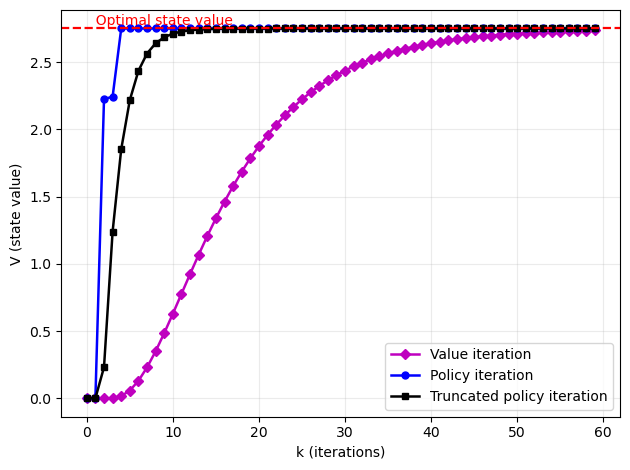

In [13]:
import matplotlib.pyplot as plt

plt.figure()

# Value Iteration: magenta line with diamond markers
plt.plot(np.arange(len(vals_vi)),  vals_vi,
         marker='D', linestyle='-', linewidth=1.8, markersize=5,
         color='m', label='Value iteration')

# Policy Iteration: blue line with circular markers
plt.plot(np.arange(len(vals_pi)),  vals_pi,
         marker='o', linestyle='-', linewidth=1.8, markersize=5,
         color='b', label='Policy iteration')

# Truncated Policy Iteration: black line with square markers
plt.plot(np.arange(len(vals_tpi)), vals_tpi,
         marker='s', linestyle='-', linewidth=1.8, markersize=5,
         color='k', label='Truncated policy iteration')

# Optimal state value: red horizontal line
y = float(V_star)
plt.axhline(y=y, color='r', linestyle='--', linewidth=1.6)
plt.text(0.01, y, '  Optimal state value', color='r', va='bottom')

plt.xlabel('k (iterations)')
plt.ylabel('V (state value)')


plt.grid(True, which='both', alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()